SCHEMITH JEREMIE

BOUASRIA AYOUB



---
TRANSFER LEARNING WITH RESNET50 AND CIFAR10


---

**Transfer Learning :**

Le "transfer learning" (apprentissage par transfert) est une approche en apprentissage automatique (machine learning) où un modèle pré-entrainé sur une tâche est utilisé comme point de départ pour résoudre une autre tâche similaire. Plutôt que de former un modèle à partir de zéro pour chaque tâche spécifique, le transfert d'apprentissage permet d'utiliser les connaissances acquises par un modèle sur une tâche source pour améliorer les performances sur une tâche cible.

**Architecture ResNet :**


L'architecture ResNet (abréviation de "Residual Networks") est une architecture de réseau de neurones profonds qui a été introduite pour remédier au problème de la rétropropagation du gradient dans les réseaux très profonds. Elle a été présentée par Kaiming He, Xiangyu Zhang, Shaoqing Ren, et Jian Sun dans leur article intitulé "Deep Residual Learning for Image Recognition" en 2015.

La caractéristique principale des architectures ResNet est l'utilisation de "raccourcis" ou "connexions résiduelles". Ces raccourcis permettent aux informations de contourner certains blocs de couches dans le réseau, ce qui facilite l'entraînement de réseaux extrêmement profonds.



---


Nous avons effectué un transfert d'apprentissage en réentraînant le modèle sur notre jeu de données spécifique tout en initiant les poids du modèle avec les valeurs préalablement apprises à partir d'un modèle pré-entraîné sur une tâche similaire. Cela nous a permis d'ajuster les paramètres du modèle pour qu'ils soient mieux adaptés à notre tâche cible, en capitalisant sur les connaissances préalables du modèle


Le dataset utilisé est le dataset CIFAR10 , qui contient 60 000 images réparties pour 10 classes différentes : Avion, Voiture , Oiseau, Chat , Biche, Chien, Grenouille, Cheval, Bateau, Camion


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from keras.utils import to_categorical

In [ ]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()



170498071/170498071 [==============================] - 8s 0us/step


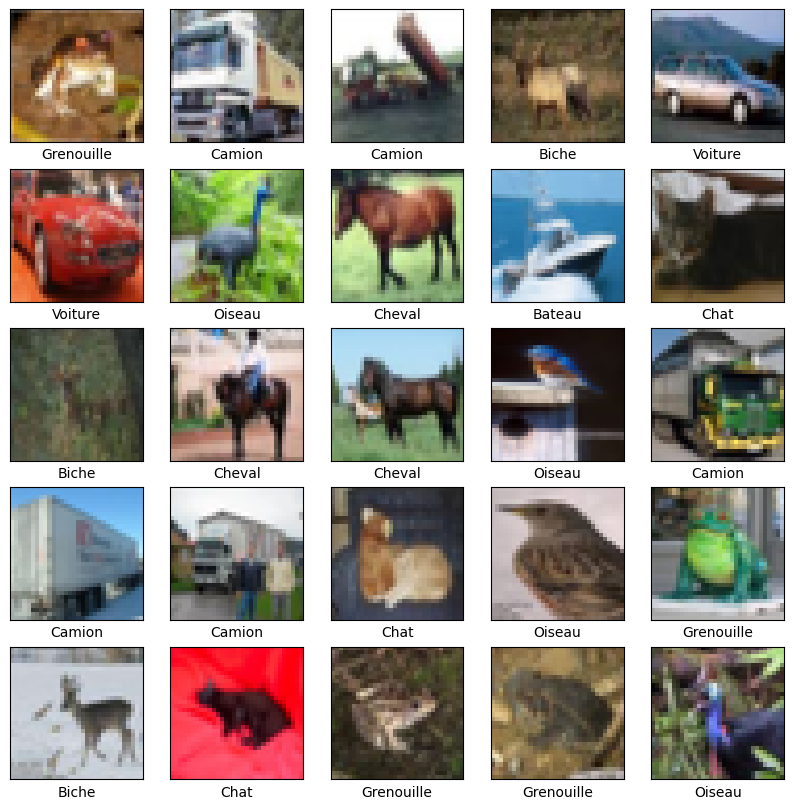

In [ ]:
class_names = ['Avion', 'Voiture' , 'Oiseau','Chat','Biche','Chien','Grenouille','Cheval','Bateau','Camion']
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[y_train[i][0]])

plt.show()

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


On réalise dans un premier temps des étapes de upsampling, le but étant de changer la résolution des images d'entrées pour qu'elles conviennent au réseau ResNet. Ici on les a agrandit 3 fois, car la taille des images utilisés pour la partie ResNet est 256x256 et nous avons des images de tailles 32x32.
On ajoute par la suite des couches convolutive présente dans les CNN.
On ajoute des couches de bruit dans le modèle pour éviter le surajustement du modèle (Dropout0
On met également des couches de normalisation (BatchNormalisation) pour accélérer la convergence de notre modèle.

In [ ]:
model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=5, batch_size=20, validation_data=(x_test, y_test))

Epoch 1/5
2500/2500 [==============================] - 703s 270ms/step - loss: 0.7197 - acc: 0.3852 - val_loss: 0.5086 - val_acc: 0.7722
Epoch 2/5
2500/2500 [==============================] - 674s 270ms/step - loss: 0.5691 - acc: 0.6261 - val_loss: 0.3836 - val_acc: 0.8675
Epoch 3/5
2500/2500 [==============================] - 674s 270ms/step - loss: 0.4468 - acc: 0.7362 - val_loss: 0.2746 - val_acc: 0.9016
Epoch 4/5
2500/2500 [==============================] - 670s 268ms/step - loss: 0.3303 - acc: 0.7988 - val_loss: 0.1858 - val_acc: 0.9119
Epoch 5/5
2500/2500 [==============================] - 668s 267ms/step - loss: 0.2351 - acc: 0.8394 - val_loss: 0.1224 - val_acc: 0.9260


In [ ]:
 model.save('my_model.h5')

In [ ]:
model = tf.keras.models.load_model('my_model.h5')

Les résultats obtenus sont de l'ordre de 90% . Pour avoir entraîné un modèle CNN avec différentes couches, on obtenait des valeurs de l'ordre de 82%. Ces écarts peuvent s'expliquer par l'utilisation du transfert learning qui permet d'entraîner le modèle sur un dataset plus grand avec plus de paramètres. Le modèle sera plus long à l'entraînement mais il pourra être réutilisé.